# LAB 3.1 - CNS (BPTT)


Import of libraries and fix of random seed.

In [1]:
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)

set_seed(0)

# Bonus track 3 -  BackPropagation Through-Time algorithm from scratch


Data loading.

In [2]:
import torch
from torchvision import datasets
import os

def download_mnist(max_categories: int = 2, max_size: int = 1000) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Function able to download MNIST dataset and return it.

    max_categories: Maximum number of categories.

    returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Training data and labels and test data and labels of MNIST dataset.
    """
    mnist_dir = 'MNIST/'
    if not os.path.exists(mnist_dir):
        os.mkdir(mnist_dir)
    TR_MNIST = datasets.MNIST(root=f'{mnist_dir}', train=True, download=True, transform=None)
    TS_MNIST = datasets.MNIST(root=f'{mnist_dir}', train=False, download=True, transform=None)
    preprocess_x = lambda x: x.reshape(-1, 28 * 28, 1).transpose(0, 1).contiguous().type(torch.float32) / 255
    return \
      preprocess_x(TR_MNIST.train_data[TR_MNIST.train_labels < max_categories]).numpy()[:, :max_size], \
      torch.nn.functional.one_hot(TR_MNIST.train_labels[TR_MNIST.train_labels < max_categories]).numpy()[:max_size], \
      preprocess_x(TS_MNIST.test_data[TS_MNIST.train_labels < max_categories]).numpy()[:, :max_size], \
      torch.nn.functional.one_hot(TS_MNIST.test_labels[TS_MNIST.train_labels < max_categories]).numpy()[:max_size]


X_TR_SET, Y_TR_SET, X_TS_SET, Y_TS_SET = download_mnist()
TR_SET = X_TR_SET, Y_TR_SET 
TS_SET = X_TS_SET, Y_TS_SET

X_TR_SET.shape, Y_TR_SET.shape, X_TS_SET.shape, Y_TS_SET.shape

/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/2_semestre/computational neuroscience/assignments/cns_lab/venv/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/geremiapompei/Library/CloudStorage/OneDr

((784, 1000, 1), (1000, 2), (784, 1000, 1), (1000, 2))

Function able to simplify the plot of loss and metric.

In [3]:
def _base_plot(tr: list, ts: list, name: str) -> None:
    """
    Function able to plot training and test loss or metric results.
    """
    plt.figure(figsize=(20, 10))
    plt.plot(tr, label=f'train {name}')
    plt.plot(ts, label=f'test {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

Cross Entropy loss function definition.

In [4]:
class CrossEntropyLoss:
    """Cross entropy loss class."""

    def __call__(self, Y: np.array, P: np.array) -> float:
        """
        Method able to compute the cross entropy loss function.

        Y: Output data.
        P: Predictions.

        returns:
            float: Cross entropy loss result.
        """
        return - (Y * np.log(P)).mean()

    def derivative(self, Y: np.array, P: np.array) -> np.array:
        """
        Function able to compute the derivative of the cross entropy loss.

        Y: Output data.
        P: Predictions.

        returns:
            float: Derivative of cross entropy loss result.
        """
        return - (Y / P) + (1 - Y) / (1 - P)
    
loss = CrossEntropyLoss()

Softmax activation function definition.

In [5]:
class Softmax:
    """Softmax activation function class."""

    def __call__(self, X: np.array) -> float:
        """
        Method able to compute the softmax function.

        X: Input data.

        returns:
            float: Softmax result.
        """
        X_exp = np.exp(X - X.max())
        return X_exp / X_exp.sum()

    def derivative(self, X: np.array) -> np.array:
        """
        Function able to compute the derivative of softmax.

        X: Input data.

        returns:
            float: Derivative of softmax result.
        """
        return self(X) * (1 - self(X))
    
softmax = Softmax()

TanH activation function definition.

In [6]:
class TanH:
    """TanH activation function class."""

    def __call__(self, X: np.array) -> float:
        """
        Method able to compute the tanh function.

        X: Input data.

        returns:
            float: Tanh result.
        """
        return np.tanh(X)

    def derivative(self, X: np.array) -> np.array:
        """
        Function able to compute the derivative of tanh.

        X: Input data.

        returns:
            float: Derivative of tanh result.
        """
        return 1 - np.tanh(X) ** 2
    
activation = TanH()

Accuracy metric function definition.

In [7]:
def accuracy(Y: np.array, P: np.array) -> float:
    """
    Accuracy metric function.

    Y: Output data.
    P: Predictions data.

    returns:
        float: Accuracy result.
    """
    return sum((Y.argmax(-1) - P.argmax(-1)) == 0) / Y.shape[0]

Class representing the vanilla RNN model where is implemented the BPTT learning algorithm.

In [8]:
class VanillaRNN:
    """
    Vanilla RNN model class.
    """

    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int,
            weights_scale: float = 0.1
    ) -> None:
        """
        Vanilla RNN model constructor method.

        input_size: Input size.
        hidden_size: Hidden size.
        output_size: Output size.
        weights_scale: Weights scale parameter. 
        """
        self.hidden_size = hidden_size

        self.w_in = (np.random.randn(input_size, hidden_size) * 2 - 1) * weights_scale
        self.w_hh = (np.random.randn(hidden_size, hidden_size) * 2 - 1) * weights_scale
        self.w_out = (np.random.randn(hidden_size, output_size) * 2 - 1) * weights_scale

        self.z_list = []
        self.h_list = []

    def __call__(self, *args, **kwargs) -> np.array:
        """
        Method able to call the forward function and return its output.

        returns:
            np.array: Forward output tensor.
        """
        return self.forward(*args, **kwargs)[0]

    def forward(
            self,
            X: np.array,
            h: np.array = None
    ) -> tuple[np.array, np.array]:
        """
        Method able to compute the forward step of the model.

        X: Input data to predict with forward method.
        h: Initial hidden state.

        returns:
            tuple[np.array, np.array]: Output and last hidden state.
        """
        if h is None:
            h = np.zeros((X.shape[1], self.hidden_size))
        self.h_list.append(h)
        for x in X:
            z = x @ self.w_in + h @ self.w_hh
            h = activation(z)
            self.z_list.append(z)
            self.h_list.append(h)
        output = softmax(h @ self.w_out)
        return output, h

    def backward(
            self,
            X: np.array,
            Y: np.array,
    ) -> tuple[np.array, np.array, np.array]:
        """
        Method able to compute the backward pass of the algorithm.

        X: Input data.
        Y: Output data.

        returns:
            tuple[np.array, np.array, np.array]: Gradients of weights.
        """
        self.z_list = []
        self.h_list = []
        P, h = self.forward(X)
        g_loss = loss.derivative(Y, P)
        D_z_list = [activation.derivative(z) for z in self.z_list]
        g_w_in, g_w_hh = 0, 0
        g_w_out = h.T @ g_loss
        delta = g_loss @ self.w_out.T * softmax.derivative(D_z_list[-1])
        for t in range(X.shape[0] - 1, -1, -1):
            for k in range(t, len(D_z_list) - 1):
                delta = delta @ self.w_hh.T * D_z_list[k]
            g_w_in += delta.T @ X[t]
            g_w_hh += delta.T @ self.h_list[t]
        return g_w_in.T, g_w_hh, g_w_out
    
    def gradient_descent(self, lr: float, g_w_in: np.array, g_w_hh: np.array, g_w_out: np.array) -> None:
        """
        Gradient descent function.

        lr: Learning rate.
        g_w_in: Gradients of w_in.
        g_w_hh: Gradients of w_hh.
        g_w_out: Gradients of w_out.
        """
        self.w_in = self.w_in - lr * g_w_in
        self.w_hh = self.w_hh - lr * g_w_hh
        self.w_out = self.w_out - lr * g_w_out

    def train(
            self,
            TR: tuple[np.array, np.array],
            TS: tuple[np.array, np.array],
            epochs: int = 10,
            lr: float = 0.01,
            clip: float = 1
    ) -> tuple[np.array, np.array, np.array, np.array]:
        """
        Method able to train the model.

        TR: Training set.
        TS: Test set.
        epochs: Number of epochs used to train the model.
        lr: Learning rate of SGD.
        clip: Hyperparameter og clipping gradient.

        returns:
            tuple[np.array, np.array, np.array, np.array]: Training and test cross entropy and accuracies.
        """
        clip_grad = lambda x: clip * x / np.linalg.norm(x)
        X_TR, Y_TR = TR
        X_TS, Y_TS = TS
        tr_loss, ts_loss, tr_metric, ts_metric = [], [], [], []

        def loss_and_metric(model, epoch):
            P_TR, P_TS = model(X_TR), model(X_TS)
            tr_l, ts_l = loss(Y_TR, P_TR), loss(Y_TS, P_TS)
            tr_m, ts_m = accuracy(Y_TR, P_TR), accuracy(Y_TS, P_TS)
            tqdm.write(f'epoch: {epoch}\ttr_loss: {tr_l}\tts_loss: {ts_l}\ttr_metric: {tr_m}\tts_metric: {ts_m}')
            tr_loss.append(tr_l), ts_loss.append(ts_l), tr_metric.append(tr_m), ts_metric.append(ts_m)

        for epoch in tqdm(range(epochs)):
            loss_and_metric(self, epoch)        
            g_w_in, g_w_hh, g_w_out = (clip_grad(w) for w in self.backward(X_TR, Y_TR))
            self.gradient_descent(lr, g_w_in, g_w_hh, g_w_out)
        loss_and_metric(self, epochs)
        return tr_loss, ts_loss, tr_metric, ts_metric

Model creation and training.

In [9]:
model = VanillaRNN(X_TR_SET.shape[-1], 10, Y_TR_SET.shape[-1], weights_scale=0.1)

tr_loss, ts_loss, tr_metric, ts_metric = model.train(TR_SET, TS_SET, epochs=100, lr=0.001)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 0	tr_loss: 3.8004571011791795	ts_loss: 3.8004562877209147	tr_metric: 0.506	ts_metric: 0.497
epoch: 1	tr_loss: 3.800456899569414	ts_loss: 3.800456114040441	tr_metric: 0.505	ts_metric: 0.496
epoch: 2	tr_loss: 3.8004567032665344	ts_loss: 3.8004559441220422	tr_metric: 0.505	ts_metric: 0.496
epoch: 3	tr_loss: 3.8004565122965057	ts_loss: 3.8004557781503525	tr_metric: 0.505	ts_metric: 0.496
epoch: 4	tr_loss: 3.8004563266629185	ts_loss: 3.8004556162691325	tr_metric: 0.505	ts_metric: 0.496
epoch: 5	tr_loss: 3.800456146349594	ts_loss: 3.8004554585859323	tr_metric: 0.506	ts_metric: 0.497
epoch: 6	tr_loss: 3.8004559713229917	ts_loss: 3.800455305176336	tr_metric: 0.505	ts_metric: 0.497
epoch: 7	tr_loss: 3.800455801534399	ts_loss: 3.800455156087808	tr_metric: 0.509	ts_metric: 0.499
epoch: 8	tr_loss: 3.8004556369219347	ts_loss: 3.8004550113431765	tr_metric: 0.509	ts_metric: 0.496
epoch: 9	tr_loss: 3.800455477412373	ts_loss: 3.800454870943774	tr_metric: 0.509	ts_metric: 0.496
epoch: 10	tr_loss:

Plot of training and test cross entropy.

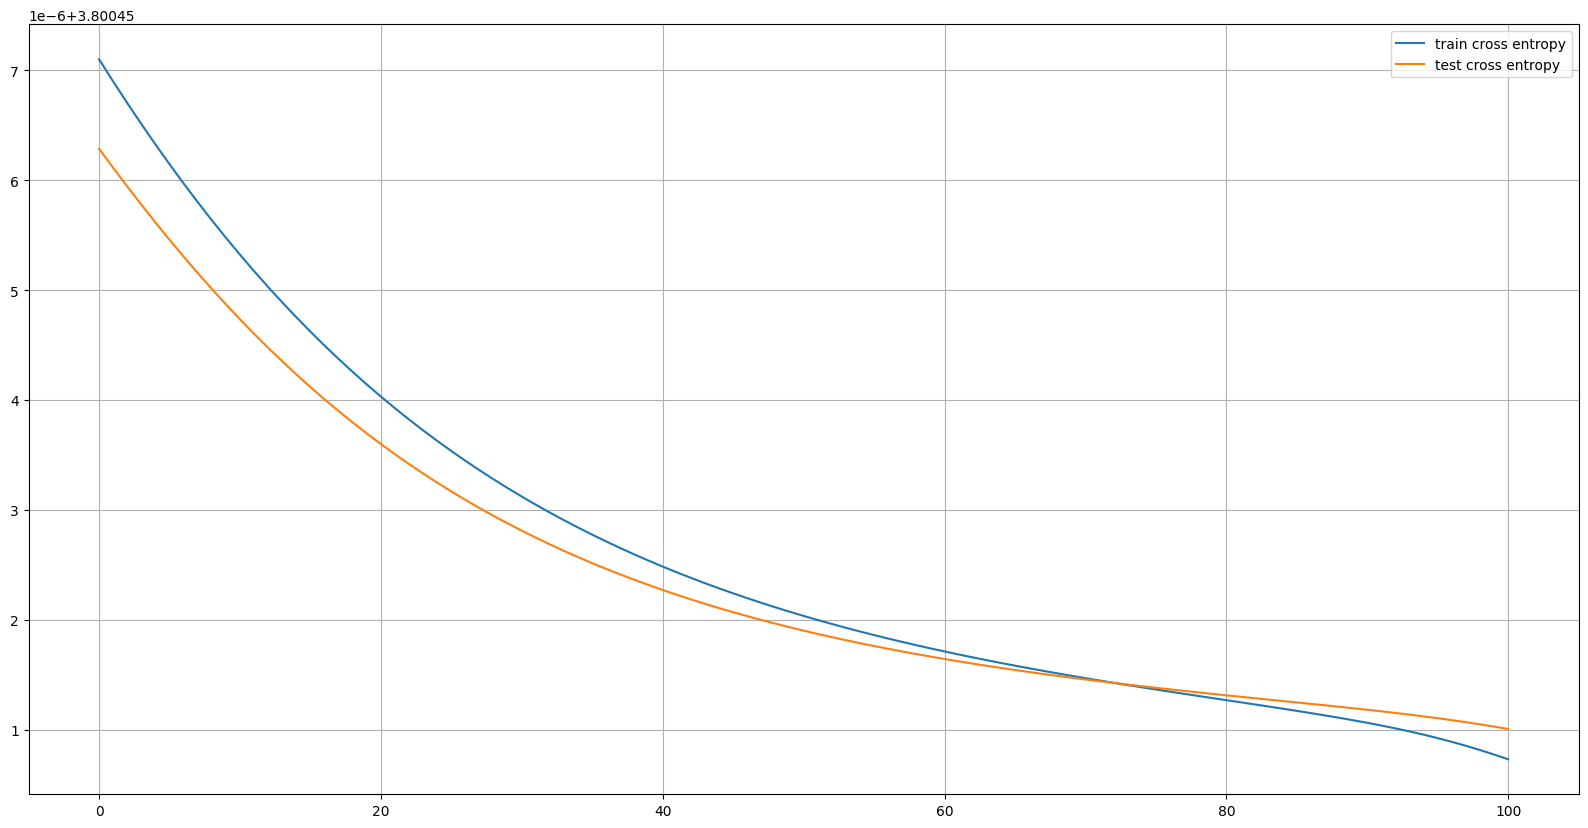

In [ ]:
_base_plot(tr_loss, ts_loss, name='cross entropy')

Plot of training and test Accuracy.

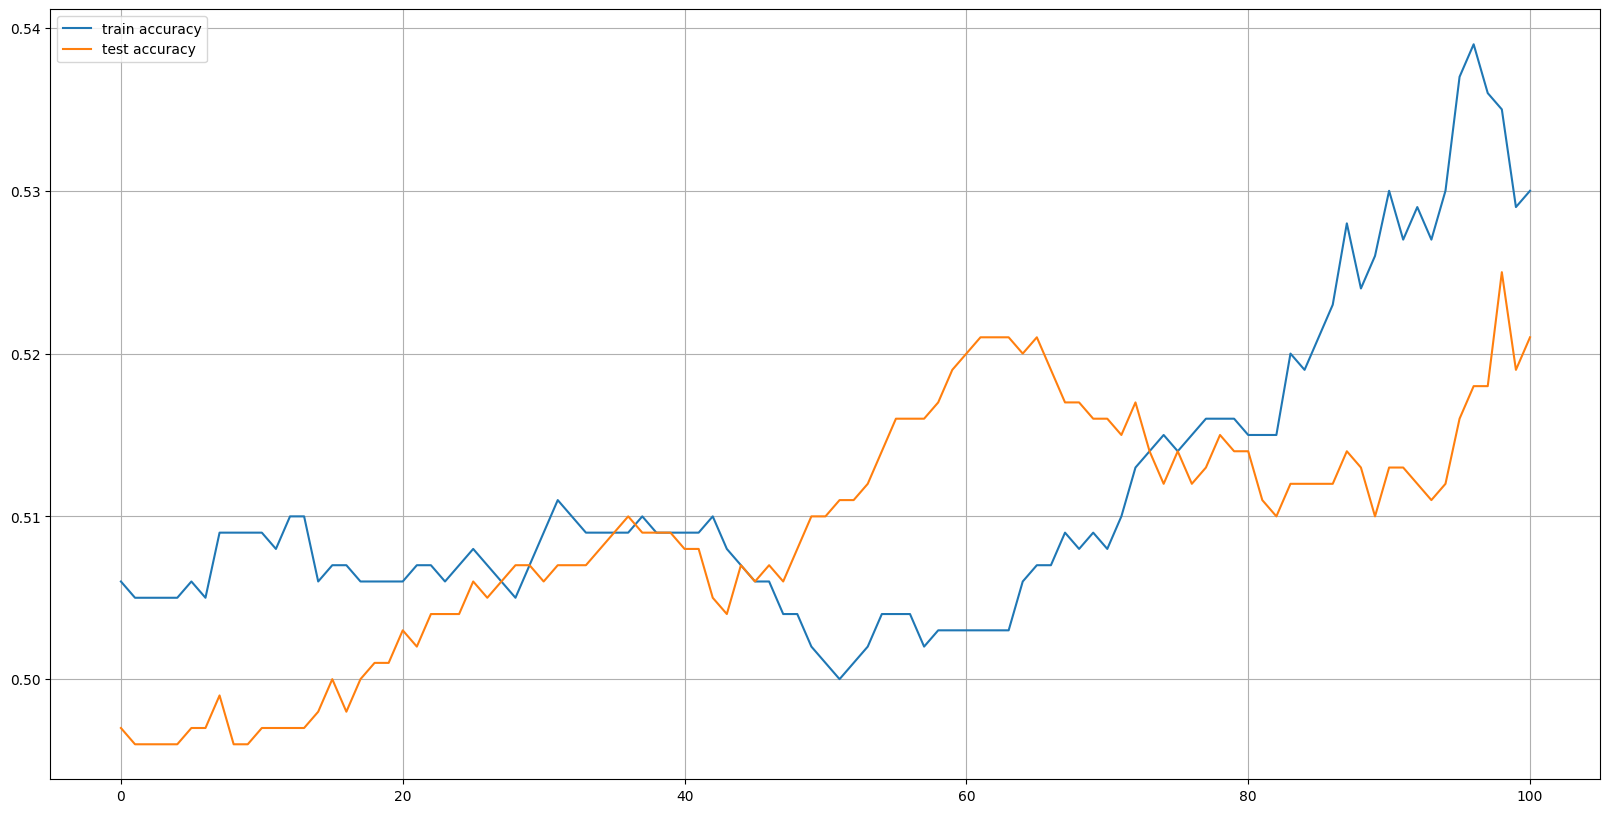

In [ ]:
_base_plot(tr_metric, ts_metric, name='accuracy')